In [ ]:
import torch

print("torch version:", torch.__version__)
print("cuda version:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


torch version: 2.5.1+cu121
cuda version: 12.1
cuda available: True
GPU name: NVIDIA GeForce RTX 3060 Laptop GPU


In [ ]:
import json
import torch
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# =========================
# ✅ 1️⃣ Config
# =========================

MODEL_NAME = "hfl/chinese-roberta-wwm-ext"

TRAIN_FILE = "train_dev_test/train.json"
DEV_FILE   = "train_dev_test/dev.json"
TEST_FILE  = "train_dev_test/test.json"

OUTPUT_DIR = "model_outputs"

MAX_LEN = 128
NUM_LABELS = 2

BATCH_SIZE = 8          
EPOCHS = 3
LR = 2e-5

# =========================
# ✅ 2️⃣ Load JSON datasets
# =========================

def load_json_dataset(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return Dataset.from_list(data)

train_ds = load_json_dataset(TRAIN_FILE)
dev_ds   = load_json_dataset(DEV_FILE)
test_ds  = load_json_dataset(TEST_FILE)

print("✅ Dataset loaded:")
print("Train:", len(train_ds))
print("Dev:  ", len(dev_ds))
print("Test: ", len(test_ds))

# =========================
# ✅ 3️⃣ Load tokenizer & model
# =========================

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
)

# =========================
# ✅ 4️⃣ Tokenization
# =========================

def tokenize(batch):
    return tokenizer(
        batch["text_zh"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN
    )

train_ds = train_ds.map(tokenize, batched=True)
dev_ds   = dev_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
dev_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# =========================
# ✅ 5️⃣ Metrics
# =========================

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro"
    )

    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "macro_f1": f1,
        "precision": precision,
        "recall": recall
    }

# =========================
# ✅ 6️⃣ Training Arguments
# =========================

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",

    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,

    num_train_epochs=EPOCHS,
    learning_rate=LR,

    fp16=True,                      
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",

    logging_steps=50,
    save_total_limit=2,
    report_to="none"
)

# =========================
# ✅ 7️⃣ Trainer
# =========================

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=dev_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# =========================
# ✅ 8️⃣ Start training
# =========================

print("\n🚀 Start fine-tuning...")
trainer.train()

# =========================
# ✅ 9️⃣ Final evaluation on test set
# =========================

print("\n📊 Final evaluation on TEST set:")
test_results = trainer.predict(test_ds)

y_pred = np.argmax(test_results.predictions, axis=1)
y_true = test_results.label_ids

print(classification_report(y_true, y_pred, digits=4))

# =========================
# ✅ 🔟 Dimension-wise F1
# =========================

print("\n📈 Dimension-wise Macro F1:")

test_meta = json.load(open(TEST_FILE, "r", encoding="utf-8"))
dims = sorted(list(set(x["dimension"] for x in test_meta)))

for dim in dims:
    idx = [i for i, x in enumerate(test_meta) if x["dimension"] == dim]

    if len(idx) < 10:
        continue

    y_d = y_true[idx]
    y_p = y_pred[idx]

    p, r, f1, _ = precision_recall_fscore_support(
        y_d, y_p, average="macro"
    )

    print(f"{dim:<12} | F1={f1:.4f} | P={p:.4f} | R={r:.4f} | N={len(idx)}")

print("\n✅ Training & evaluation finished!")


✅ Dataset loaded:
Train: 1949
Dev:   240
Test:  251


e:\conda_envs\hearts_env\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\13514\.cache\huggingface\hub\models--hfl--chinese-roberta-wwm-ext. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-roberta-


🚀 Start fine-tuning...


  7%|▋         | 52/732 [00:06<01:10,  9.58it/s]

{'loss': 0.6508, 'grad_norm': 6.509921073913574, 'learning_rate': 1.8633879781420766e-05, 'epoch': 0.2}


 14%|█▍        | 101/732 [00:11<01:05,  9.68it/s]

{'loss': 0.6147, 'grad_norm': 7.497180938720703, 'learning_rate': 1.726775956284153e-05, 'epoch': 0.41}


 21%|██        | 152/732 [00:16<00:59,  9.78it/s]

{'loss': 0.5682, 'grad_norm': 7.711912155151367, 'learning_rate': 1.592896174863388e-05, 'epoch': 0.61}


 27%|██▋       | 201/732 [00:21<00:55,  9.50it/s]

{'loss': 0.5289, 'grad_norm': 9.144533157348633, 'learning_rate': 1.4562841530054646e-05, 'epoch': 0.82}


                                                 
 33%|███▎      | 244/732 [00:26<00:52,  9.29it/s]

{'eval_loss': 0.5086261630058289, 'eval_accuracy': 0.6916666666666667, 'eval_macro_f1': 0.6552527370137433, 'eval_precision': 0.6686507936507937, 'eval_recall': 0.6511111111111111, 'eval_runtime': 0.7079, 'eval_samples_per_second': 339.049, 'eval_steps_per_second': 42.381, 'epoch': 1.0}


 34%|███▍      | 251/732 [00:29<01:31,  5.24it/s]

{'loss': 0.5891, 'grad_norm': 4.594933032989502, 'learning_rate': 1.3196721311475412e-05, 'epoch': 1.02}


 41%|████▏     | 302/732 [00:34<00:44,  9.75it/s]

{'loss': 0.4313, 'grad_norm': 5.852789878845215, 'learning_rate': 1.1830601092896176e-05, 'epoch': 1.23}


 48%|████▊     | 351/732 [00:39<00:38,  9.77it/s]

{'loss': 0.4022, 'grad_norm': 7.167681694030762, 'learning_rate': 1.046448087431694e-05, 'epoch': 1.43}


 55%|█████▍    | 401/732 [00:44<00:34,  9.63it/s]

{'loss': 0.4119, 'grad_norm': 8.984713554382324, 'learning_rate': 9.098360655737707e-06, 'epoch': 1.64}


 62%|██████▏   | 452/732 [00:49<00:29,  9.54it/s]

{'loss': 0.3872, 'grad_norm': 6.189863681793213, 'learning_rate': 7.732240437158471e-06, 'epoch': 1.84}


                                                 
 67%|██████▋   | 488/732 [00:54<00:25,  9.76it/s]

{'eval_loss': 0.5780959725379944, 'eval_accuracy': 0.7166666666666667, 'eval_macro_f1': 0.7027105800058292, 'eval_precision': 0.7004886461626905, 'eval_recall': 0.7066666666666667, 'eval_runtime': 0.7091, 'eval_samples_per_second': 338.461, 'eval_steps_per_second': 42.308, 'epoch': 2.0}


 69%|██████▊   | 502/732 [00:57<00:26,  8.70it/s]

{'loss': 0.3763, 'grad_norm': 6.318998336791992, 'learning_rate': 6.366120218579236e-06, 'epoch': 2.05}


 75%|███████▌  | 551/732 [01:02<00:18,  9.62it/s]

{'loss': 0.2227, 'grad_norm': 13.291308403015137, 'learning_rate': 5e-06, 'epoch': 2.25}


 82%|████████▏ | 601/732 [01:07<00:13,  9.48it/s]

{'loss': 0.2287, 'grad_norm': 4.820932865142822, 'learning_rate': 3.6338797814207656e-06, 'epoch': 2.46}


 89%|████████▉ | 652/732 [01:12<00:08,  9.69it/s]

{'loss': 0.2101, 'grad_norm': 15.877178192138672, 'learning_rate': 2.295081967213115e-06, 'epoch': 2.66}


 96%|█████████▌| 702/732 [01:17<00:03,  9.75it/s]

{'loss': 0.2555, 'grad_norm': 9.152300834655762, 'learning_rate': 9.289617486338799e-07, 'epoch': 2.87}


                                                 
100%|██████████| 732/732 [01:23<00:00,  9.78it/s]

{'eval_loss': 0.7538101673126221, 'eval_accuracy': 0.7166666666666667, 'eval_macro_f1': 0.7108638650698037, 'eval_precision': 0.7127363737486097, 'eval_recall': 0.7266666666666667, 'eval_runtime': 0.6798, 'eval_samples_per_second': 353.037, 'eval_steps_per_second': 44.13, 'epoch': 3.0}


100%|██████████| 732/732 [01:24<00:00,  8.62it/s]


{'train_runtime': 84.9454, 'train_samples_per_second': 68.832, 'train_steps_per_second': 8.617, 'train_loss': 0.41408125429205556, 'epoch': 3.0}

📊 Final evaluation on TEST set:


100%|██████████| 32/32 [00:00<00:00, 45.92it/s]

              precision    recall  f1-score   support

           0     0.8043    0.7115    0.7551       156
           1     0.6018    0.7158    0.6538        95

    accuracy                         0.7131       251
   macro avg     0.7031    0.7137    0.7045       251
weighted avg     0.7277    0.7131    0.7168       251


📈 Dimension-wise Macro F1:
age          | F1=0.5906 | P=0.6515 | R=0.6042 | N=14
education    | F1=1.0000 | P=1.0000 | R=1.0000 | N=16
gender       | F1=0.6237 | P=0.6284 | R=0.6210 | N=82
nationality  | F1=0.7333 | P=0.7323 | R=0.7738 | N=40
profession   | F1=0.6165 | P=0.6236 | R=0.6389 | N=81
region       | F1=1.0000 | P=1.0000 | R=1.0000 | N=18

✅ Training & evaluation finished!


In [ ]:
import json
import torch
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# =========================
# ✅ 1️⃣ Config
# =========================

MODEL_NAME = "hfl/chinese-macbert-base"

TRAIN_FILE = "train_dev_test/train.json"
DEV_FILE   = "train_dev_test/dev.json"
TEST_FILE  = "train_dev_test/test.json"

OUTPUT_DIR = "model_outputs_macbert"

MAX_LEN = 128
NUM_LABELS = 2

BATCH_SIZE = 8         
EPOCHS = 3
LR = 2e-5

# =========================
# ✅ 2️⃣ Load JSON datasets
# =========================

def load_json_dataset(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return Dataset.from_list(data)

train_ds = load_json_dataset(TRAIN_FILE)
dev_ds   = load_json_dataset(DEV_FILE)
test_ds  = load_json_dataset(TEST_FILE)

print("✅ Dataset loaded:")
print("Train:", len(train_ds))
print("Dev:  ", len(dev_ds))
print("Test: ", len(test_ds))

# =========================
# ✅ 3️⃣ Load tokenizer & model
# =========================

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
)

# =========================
# ✅ 4️⃣ Tokenization
# =========================

def tokenize(batch):
    return tokenizer(
        batch["text_zh"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN
    )

train_ds = train_ds.map(tokenize, batched=True)
dev_ds   = dev_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

train_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
dev_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# =========================
# ✅ 5️⃣ Metrics
# =========================

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro"
    )

    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "macro_f1": f1,
        "precision": precision,
        "recall": recall
    }

# =========================
# ✅ 6️⃣ Training Arguments
# =========================

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",

    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,

    num_train_epochs=EPOCHS,
    learning_rate=LR,

    fp16=True,                      
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",

    logging_steps=50,
    save_total_limit=2,
    report_to="none"
)

# =========================
# ✅ 7️⃣ Trainer
# =========================

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=dev_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# =========================
# ✅ 8️⃣ Start training
# =========================

print("\n🚀 Start fine-tuning...")
trainer.train()

# =========================
# ✅ 9️⃣ Final evaluation on test set
# =========================

print("\n📊 Final evaluation on TEST set:")
test_results = trainer.predict(test_ds)

y_pred = np.argmax(test_results.predictions, axis=1)
y_true = test_results.label_ids

print(classification_report(y_true, y_pred, digits=4))

# =========================
# ✅ 🔟 Dimension-wise F1
# =========================

print("\n📈 Dimension-wise Macro F1:")

test_meta = json.load(open(TEST_FILE, "r", encoding="utf-8"))
dims = sorted(list(set(x["dimension"] for x in test_meta)))

for dim in dims:
    idx = [i for i, x in enumerate(test_meta) if x["dimension"] == dim]

    if len(idx) < 10:
        continue

    y_d = y_true[idx]
    y_p = y_pred[idx]

    p, r, f1, _ = precision_recall_fscore_support(
        y_d, y_p, average="macro"
    )

    print(f"{dim:<12} | F1={f1:.4f} | P={p:.4f} | R={r:.4f} | N={len(idx)}")

print("\n✅ Training & evaluation finished!")


✅ Dataset loaded:
Train: 1949
Dev:   240
Test:  251


e:\conda_envs\hearts_env\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\13514\.cache\huggingface\hub\models--hfl--chinese-macbert-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-macbert-bas


🚀 Start fine-tuning...


  7%|▋         | 52/732 [00:05<01:12,  9.33it/s]

{'loss': 0.6482, 'grad_norm': 7.717759132385254, 'learning_rate': 1.8633879781420766e-05, 'epoch': 0.2}


 14%|█▍        | 101/732 [00:10<01:07,  9.35it/s]

{'loss': 0.5986, 'grad_norm': 10.017861366271973, 'learning_rate': 1.7295081967213117e-05, 'epoch': 0.41}


 21%|██        | 151/732 [00:16<01:05,  8.94it/s]

{'loss': 0.5551, 'grad_norm': 10.347472190856934, 'learning_rate': 1.598360655737705e-05, 'epoch': 0.61}


 28%|██▊       | 202/732 [00:21<00:55,  9.52it/s]

{'loss': 0.5362, 'grad_norm': 11.482223510742188, 'learning_rate': 1.4617486338797816e-05, 'epoch': 0.82}


 33%|███▎      | 244/732 [00:26<00:54,  8.88it/s]

{'eval_loss': 0.4986269772052765, 'eval_accuracy': 0.7125, 'eval_macro_f1': 0.6795107507112307, 'eval_precision': 0.6931752932491182, 'eval_recall': 0.6744444444444444, 'eval_runtime': 0.733, 'eval_samples_per_second': 327.419, 'eval_steps_per_second': 40.927, 'epoch': 1.0}


 34%|███▍      | 252/732 [00:30<01:33,  5.15it/s]

{'loss': 0.582, 'grad_norm': 6.054258346557617, 'learning_rate': 1.325136612021858e-05, 'epoch': 1.02}


 41%|████▏     | 302/732 [00:35<00:45,  9.51it/s]

{'loss': 0.4399, 'grad_norm': 8.201187133789062, 'learning_rate': 1.1885245901639346e-05, 'epoch': 1.23}


 48%|████▊     | 352/732 [00:40<00:39,  9.51it/s]

{'loss': 0.4133, 'grad_norm': 14.110542297363281, 'learning_rate': 1.051912568306011e-05, 'epoch': 1.43}


 55%|█████▍    | 402/732 [00:46<00:34,  9.44it/s]

{'loss': 0.453, 'grad_norm': 10.41930103302002, 'learning_rate': 9.153005464480875e-06, 'epoch': 1.64}


 62%|██████▏   | 452/732 [00:51<00:29,  9.53it/s]

{'loss': 0.4161, 'grad_norm': 4.6799726486206055, 'learning_rate': 7.786885245901639e-06, 'epoch': 1.84}


 67%|██████▋   | 488/732 [00:56<00:25,  9.43it/s]

{'eval_loss': 0.5539634823799133, 'eval_accuracy': 0.6958333333333333, 'eval_macro_f1': 0.6762689628411465, 'eval_precision': 0.6758979275757799, 'eval_recall': 0.6766666666666666, 'eval_runtime': 0.7182, 'eval_samples_per_second': 334.163, 'eval_steps_per_second': 41.77, 'epoch': 2.0}


 69%|██████▊   | 502/732 [00:59<00:26,  8.81it/s]

{'loss': 0.3886, 'grad_norm': 6.161891937255859, 'learning_rate': 6.420765027322405e-06, 'epoch': 2.05}


 75%|███████▌  | 552/732 [01:04<00:18,  9.47it/s]

{'loss': 0.2432, 'grad_norm': 28.114404678344727, 'learning_rate': 5.0546448087431695e-06, 'epoch': 2.25}


 82%|████████▏ | 601/732 [01:10<00:13,  9.45it/s]

{'loss': 0.2167, 'grad_norm': 7.005916595458984, 'learning_rate': 3.6885245901639347e-06, 'epoch': 2.46}


 89%|████████▉ | 652/732 [01:15<00:08,  9.45it/s]

{'loss': 0.1992, 'grad_norm': 24.93905258178711, 'learning_rate': 2.3224043715847e-06, 'epoch': 2.66}


 96%|█████████▌| 702/732 [01:20<00:03,  9.50it/s]

{'loss': 0.2774, 'grad_norm': 14.673905372619629, 'learning_rate': 9.562841530054645e-07, 'epoch': 2.87}


100%|██████████| 732/732 [01:26<00:00,  9.43it/s]

{'eval_loss': 0.7171931862831116, 'eval_accuracy': 0.7125, 'eval_macro_f1': 0.7062527716186253, 'eval_precision': 0.7076521739130435, 'eval_recall': 0.721111111111111, 'eval_runtime': 0.704, 'eval_samples_per_second': 340.901, 'eval_steps_per_second': 42.613, 'epoch': 3.0}


100%|██████████| 732/732 [01:28<00:00,  8.31it/s]


{'train_runtime': 88.0926, 'train_samples_per_second': 66.373, 'train_steps_per_second': 8.309, 'train_loss': 0.4187600912292147, 'epoch': 3.0}

📊 Final evaluation on TEST set:


100%|██████████| 32/32 [00:00<00:00, 45.59it/s]

              precision    recall  f1-score   support

           0     0.8438    0.6923    0.7606       156
           1     0.6098    0.7895    0.6881        95

    accuracy                         0.7291       251
   macro avg     0.7268    0.7409    0.7243       251
weighted avg     0.7552    0.7291    0.7331       251


📈 Dimension-wise Macro F1:
age          | F1=0.7754 | P=0.7889 | R=0.7708 | N=14
education    | F1=1.0000 | P=1.0000 | R=1.0000 | N=16
gender       | F1=0.7147 | P=0.7108 | R=0.7275 | N=82
nationality  | F1=0.7679 | P=0.7857 | R=0.8393 | N=40
profession   | F1=0.5653 | P=0.5742 | R=0.5833 | N=81
region       | F1=1.0000 | P=1.0000 | R=1.0000 | N=18

✅ Training & evaluation finished!


In [10]:
import json
import torch
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification
)
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm

# =========================
# ✅ 1️⃣ Basic Configuration
# =========================

TEST_FILE = "train_dev_test/test.json"
BATCH_SIZE = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODELS = {
    "roberta_pretrained": "hfl/chinese-roberta-wwm-ext",
    "macbert_pretrained": "hfl/chinese-macbert-base",
    "roberta_finetuned": "model_outputs/checkpoint-732",
    "macbert_finetuned": "model_outputs_macbert/checkpoint-732"
}

# =========================
# ✅ 2️⃣ Load Test Set
# =========================

with open(TEST_FILE, "r", encoding="utf-8") as f:
    test_data = json.load(f)

texts = [x["text_zh"] for x in test_data]
labels = [x["label"] for x in test_data]

print(f"✅ Loaded test set: {len(texts)} samples")

# =========================
# ✅ 3️⃣ Dataset Wrapper
# =========================

class ZhDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# =========================
# ✅ 4️⃣ Single Model Evaluation Function
# =========================

def evaluate_model(name, model_path):
    print(f"\n==============================")
    print(f"🚀 Evaluating: {name}")
    print(f"📦 Model path: {model_path}")

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(DEVICE)
    model.eval()

    dataset = ZhDataset(texts, labels, tokenizer)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels_batch = batch["labels"].to(DEVICE)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")

    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, digits=4))

    print(f"✅ Accuracy  = {acc:.4f}")
    print(f"✅ Macro F1  = {macro_f1:.4f}")

    return {
        "model": name,
        "accuracy": acc,
        "macro_f1": macro_f1
    }

# =========================
# ✅ 5️⃣ Run Evaluation for Four Models
# =========================

all_results = []

for name, path in MODELS.items():
    result = evaluate_model(name, path)
    all_results.append(result)

# =========================
# ✅ 6️⃣ Final Comparison Summary
# =========================

print("\n=======================================")
print("📊 FINAL COMPARISON (ALL 4 MODELS)")
print("=======================================\n")

for r in all_results:
    print(f"{r['model']:25s} | Acc={r['accuracy']:.4f} | Macro-F1={r['macro_f1']:.4f}")


✅ Loaded test set: 251 samples

🚀 Evaluating: roberta_pretrained
📦 Model path: hfl/chinese-roberta-wwm-ext


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-roberta-wwm-ext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 32/32 [00:01<00:00, 16.73it/s]
e:\conda_envs\hearts_env\lib\site-packages\sklearn\metrics\_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\conda_envs\hearts_env\lib\site-packages\sklearn\metrics\_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\conda_


📊 Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       156
           1     0.3785    1.0000    0.5491        95

    accuracy                         0.3785       251
   macro avg     0.1892    0.5000    0.2746       251
weighted avg     0.1433    0.3785    0.2078       251

✅ Accuracy  = 0.3785
✅ Macro F1  = 0.2746

🚀 Evaluating: macbert_pretrained
📦 Model path: hfl/chinese-macbert-base


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-macbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 32/32 [00:01<00:00, 16.20it/s]



📊 Classification Report:
              precision    recall  f1-score   support

           0     0.7692    0.0641    0.1183       156
           1     0.3866    0.9684    0.5526        95

    accuracy                         0.4064       251
   macro avg     0.5779    0.5163    0.3354       251
weighted avg     0.6244    0.4064    0.2827       251

✅ Accuracy  = 0.4064
✅ Macro F1  = 0.3354

🚀 Evaluating: roberta_finetuned
📦 Model path: model_outputs/checkpoint-732


100%|██████████| 32/32 [00:02<00:00, 15.61it/s]



📊 Classification Report:
              precision    recall  f1-score   support

           0     0.8043    0.7115    0.7551       156
           1     0.6018    0.7158    0.6538        95

    accuracy                         0.7131       251
   macro avg     0.7031    0.7137    0.7045       251
weighted avg     0.7277    0.7131    0.7168       251

✅ Accuracy  = 0.7131
✅ Macro F1  = 0.7045

🚀 Evaluating: macbert_finetuned
📦 Model path: model_outputs_macbert/checkpoint-732


100%|██████████| 32/32 [00:02<00:00, 15.93it/s]


📊 Classification Report:
              precision    recall  f1-score   support

           0     0.8438    0.6923    0.7606       156
           1     0.6098    0.7895    0.6881        95

    accuracy                         0.7291       251
   macro avg     0.7268    0.7409    0.7243       251
weighted avg     0.7552    0.7291    0.7331       251

✅ Accuracy  = 0.7291
✅ Macro F1  = 0.7243

📊 FINAL COMPARISON (ALL 4 MODELS)

roberta_pretrained        | Acc=0.3785 | Macro-F1=0.2746
macbert_pretrained        | Acc=0.4064 | Macro-F1=0.3354
roberta_finetuned         | Acc=0.7131 | Macro-F1=0.7045
macbert_finetuned         | Acc=0.7291 | Macro-F1=0.7243


In [12]:
import json
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm
from collections import defaultdict

# =========================
# ✅ 1️⃣ Configuration
# =========================

TEST_FILE = "train_dev_test/test.json"

# ✅ Model to evaluate (choose one)
MODEL_PATH = "model_outputs/checkpoint-732"
# MODEL_PATH = "model_outputs_macbert/checkpoint-732"

BATCH_SIZE = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TARGET_DIMENSIONS = [
    "gender",
    "nationality",
    "age",
    "profession",
    "education",
    "region"
]

# =========================
# ✅ 2️⃣ Load test set
# =========================

with open(TEST_FILE, "r", encoding="utf-8") as f:
    test_data = json.load(f)

print(f"✅ Loaded test set: {len(test_data)} samples")

# =========================
# ✅ 3️⃣ Dataset wrapper
# =========================

class ZhDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.texts = [x["text_zh"] for x in data]
        self.labels = [x["label"] for x in data]
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# =========================
# ✅ 4️⃣ Load model
# =========================

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
model.to(DEVICE)
model.eval()

dataset = ZhDataset(test_data, tokenizer)
loader = DataLoader(dataset, batch_size=BATCH_SIZE)

# =========================
# ✅ 5️⃣ Run inference
# =========================

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(loader, desc="Predicting"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# =========================
# ✅ 6️⃣ Split predictions by dimension
# =========================

dim_stats = defaultdict(list)

for i, item in enumerate(test_data):
    dim = item["dimension"]
    if dim in TARGET_DIMENSIONS:
        dim_stats[dim].append((
            all_labels[i],
            all_preds[i]
        ))

# =========================
# ✅ 7️⃣ Output metrics per dimension
# =========================

print("\n📈 Dimension-wise Macro F1:")
print("-" * 60)

for dim in TARGET_DIMENSIONS:
    y_true = [x[0] for x in dim_stats[dim]]
    y_pred = [x[1] for x in dim_stats[dim]]

    if len(y_true) == 0:
        print(f"{dim:12s} | No samples")
        continue

    p, r, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average="macro",
        zero_division=0
    )

    print(f"{dim:12s} | F1={f1:.4f} | P={p:.4f} | R={r:.4f} | N={len(y_true)}")


✅ Loaded test set: 251 samples


Predicting: 100%|██████████| 32/32 [00:02<00:00, 15.97it/s]


📈 Dimension-wise Macro F1:
------------------------------------------------------------
gender       | F1=0.6237 | P=0.6284 | R=0.6210 | N=82
nationality  | F1=0.7333 | P=0.7323 | R=0.7738 | N=40
age          | F1=0.5906 | P=0.6515 | R=0.6042 | N=14
profession   | F1=0.6165 | P=0.6236 | R=0.6389 | N=81
education    | F1=1.0000 | P=1.0000 | R=1.0000 | N=16
region       | F1=1.0000 | P=1.0000 | R=1.0000 | N=18


In [13]:
import json
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm
from collections import defaultdict

# =========================
# ✅ 1️⃣ Configuration
# =========================

TEST_FILE = "train_dev_test/test.json"

# ✅ Model to evaluate (choose one)
# MODEL_PATH = "model_outputs/checkpoint-732"
MODEL_PATH = "model_outputs_macbert/checkpoint-732"

BATCH_SIZE = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TARGET_DIMENSIONS = [
    "gender",
    "nationality",
    "age",
    "profession",
    "education",
    "region"
]

# =========================
# ✅ 2️⃣ Load test set
# =========================

with open(TEST_FILE, "r", encoding="utf-8") as f:
    test_data = json.load(f)

print(f"✅ Loaded test set: {len(test_data)} samples")

# =========================
# ✅ 3️⃣ Dataset wrapper
# =========================

class ZhDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.texts = [x["text_zh"] for x in data]
        self.labels = [x["label"] for x in data]
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# =========================
# ✅ 4️⃣ Load model
# =========================

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
model.to(DEVICE)
model.eval()

dataset = ZhDataset(test_data, tokenizer)
loader = DataLoader(dataset, batch_size=BATCH_SIZE)

# =========================
# ✅ 5️⃣ Run inference
# =========================

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(loader, desc="Predicting"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# =========================
# ✅ 6️⃣ Split predictions by dimension
# =========================

dim_stats = defaultdict(list)

for i, item in enumerate(test_data):
    dim = item["dimension"]
    if dim in TARGET_DIMENSIONS:
        dim_stats[dim].append((
            all_labels[i],
            all_preds[i]
        ))

# =========================
# ✅ 7️⃣ Output metrics per dimension
# =========================

print("\n📈 Dimension-wise Macro F1:")
print("-" * 60)

for dim in TARGET_DIMENSIONS:
    y_true = [x[0] for x in dim_stats[dim]]
    y_pred = [x[1] for x in dim_stats[dim]]

    if len(y_true) == 0:
        print(f"{dim:12s} | No samples")
        continue

    p, r, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average="macro",
        zero_division=0
    )

    print(f"{dim:12s} | F1={f1:.4f} | P={p:.4f} | R={r:.4f} | N={len(y_true)}")


✅ Loaded test set: 251 samples


Predicting: 100%|██████████| 32/32 [00:02<00:00, 15.93it/s]


📈 Dimension-wise Macro F1:
------------------------------------------------------------
gender       | F1=0.7147 | P=0.7108 | R=0.7275 | N=82
nationality  | F1=0.7679 | P=0.7857 | R=0.8393 | N=40
age          | F1=0.7754 | P=0.7889 | R=0.7708 | N=14
profession   | F1=0.5653 | P=0.5742 | R=0.5833 | N=81
education    | F1=1.0000 | P=1.0000 | R=1.0000 | N=16
region       | F1=1.0000 | P=1.0000 | R=1.0000 | N=18


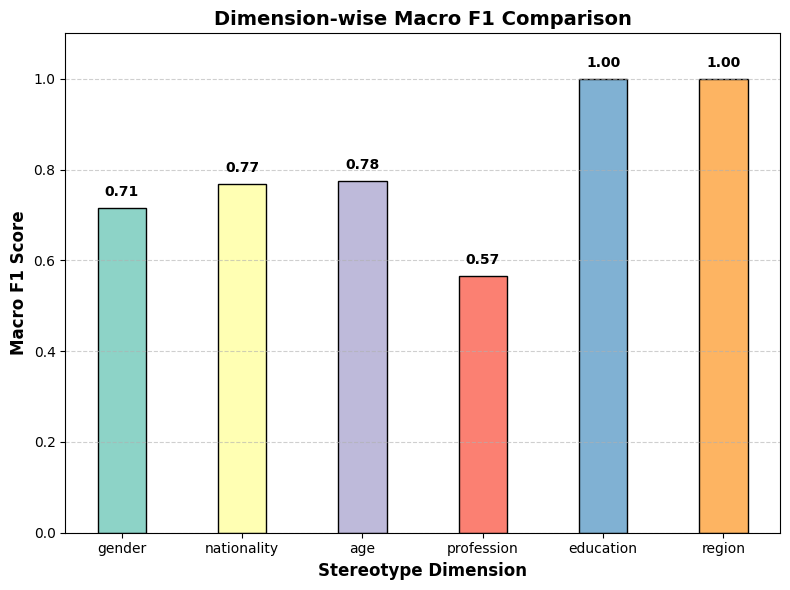

In [19]:
import matplotlib.pyplot as plt

# Data
dimensions = ["gender", "nationality", "age", "profession", "education", "region"]
f1_scores = [0.7147, 0.7679, 0.7754, 0.5653, 1.0000, 1.0000]

# Create figure
plt.figure(figsize=(8,6))

# Use a softer color palette (pastel style)
colors = plt.cm.Set3(range(len(dimensions)))

# Bar chart with narrower width
bars = plt.bar(dimensions, f1_scores, 
               color=colors, edgecolor="black", linewidth=1.0, width=0.4)

# Add value labels on top of bars
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f"{score:.2f}", ha="center", va="bottom", fontsize=10, fontweight="bold")

# Labels and title with improved font size
plt.xlabel("Stereotype Dimension", fontsize=12, fontweight="bold")
plt.ylabel("Macro F1 Score", fontsize=12, fontweight="bold")
plt.title("Dimension-wise Macro F1 Comparison", fontsize=14, fontweight="bold")

# Set y-axis limit and grid
plt.ylim(0, 1.1)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


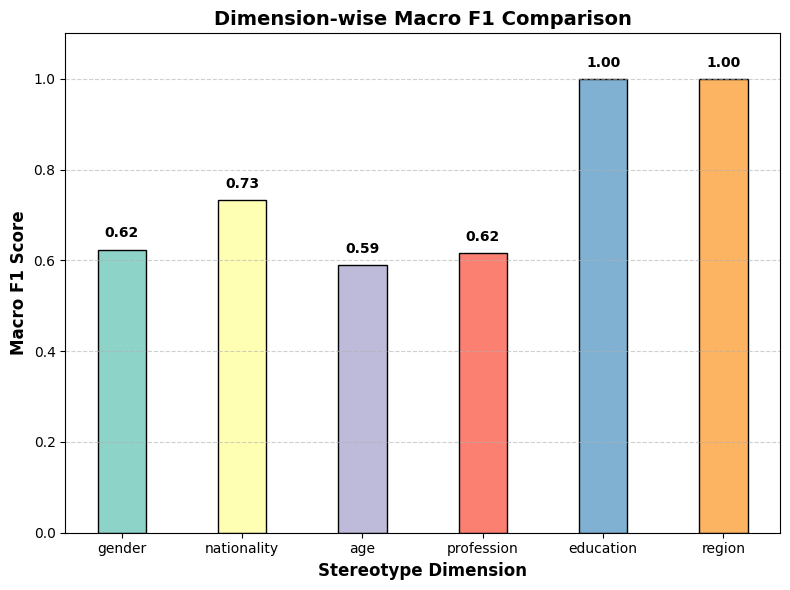

In [18]:
import matplotlib.pyplot as plt

# Data
dimensions = ["gender", "nationality", "age", "profession", "education", "region"]
f1_scores = [0.6237, 0.7333, 0.5906, 0.6165, 1.0000, 1.0000]

# Create figure
plt.figure(figsize=(8,6))

# Use a softer color palette (pastel style)
colors = plt.cm.Set3(range(len(dimensions)))

# Bar chart with narrower width
bars = plt.bar(dimensions, f1_scores, 
               color=colors, edgecolor="black", linewidth=1.0, width=0.4)

# Add value labels on top of bars
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f"{score:.2f}", ha="center", va="bottom", fontsize=10, fontweight="bold")

# Labels and title with improved font size
plt.xlabel("Stereotype Dimension", fontsize=12, fontweight="bold")
plt.ylabel("Macro F1 Score", fontsize=12, fontweight="bold")
plt.title("Dimension-wise Macro F1 Comparison", fontsize=14, fontweight="bold")

# Set y-axis limit and grid
plt.ylim(0, 1.1)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


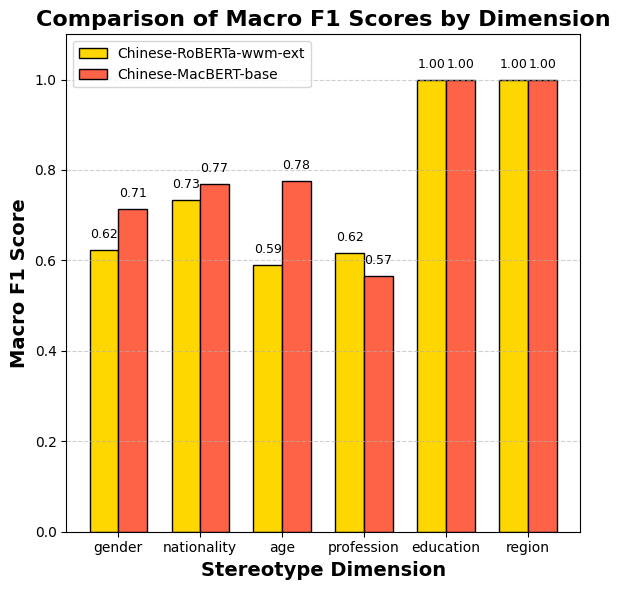

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Data
dimensions = ["gender", "nationality", "age", "profession", "education", "region"]
roberta_scores = [0.6237, 0.7333, 0.5906, 0.6165, 1.0000, 1.0000]
macbert_scores = [0.7147, 0.7679, 0.7754, 0.5653, 1.0000, 1.0000]

x = np.arange(len(dimensions))  
width = 0.35  

plt.figure(figsize=(6,6))

bars1 = plt.bar(x - width/2, roberta_scores, width, 
                label="Chinese-RoBERTa-wwm-ext", color="gold", edgecolor="black")
bars2 = plt.bar(x + width/2, macbert_scores, width, 
                label="Chinese-MacBERT-base", color="tomato", edgecolor="black")

for bar in bars1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f"{bar.get_height():.2f}", ha="center", va="bottom", fontsize=9)
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f"{bar.get_height():.2f}", ha="center", va="bottom", fontsize=9)

plt.xticks(x, dimensions)
plt.xlabel("Stereotype Dimension", fontsize=14, fontweight="bold")
plt.ylabel("Macro F1 Score", fontsize=14, fontweight="bold")
plt.title("Comparison of Macro F1 Scores by Dimension", fontsize=16, fontweight="bold")

plt.ylim(0, 1.1)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.legend()
plt.tight_layout()
plt.show()
